# State of the Tech Labor Market - EDA & Dashboard

## Overview

According to [layoffs.fyi](layoffs.fyi) on Feb. 1, since the beginning of this year, over 85,000 people in the tech industry have lost their jobs. Given these massive numbers, I thought it would be helpful to take a deeper look at the state of the industry to get a sense of what is really going on behind the scenes -- and to see whether there is hope for any of us out there who are looking for a job.

In this notebook, I created an interactive dashboard to paint a picture of the tech labor market, split into three sections. The first gives a general sense of economic conditions in the sector more generally, the second takes a closer look at recent layoffs and predicts whether companies will experience multiple rounds or just a one off, and the third focuses on job postings.


The data for this project came from several sources:
* [layoffs.fyi](https://layoffs.fyi/)
* [U.S. Census Bureau - API](https://api.census.gov/data/timeseries/eits/bfs.html)
* [Simply WallSt](https://simplywall.st/markets/us/tech)
* [Crunchbase](https://www.crunchbase.com/)
* [U.S. Bureau of Labor Statistics](https://www.bls.gov/)
* [Kaggle / Affinity / Lightcast)](https://www.kaggle.com/datasets/douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us)
* [Indeed Hiring Lab](https://www.hiringlab.org/)
* [Yahoo Finance](https://finance.yahoo.com/)

## Import Statements

In [107]:
import pandas as pd
import numpy as np

import string
import re
import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html, dcc, dash_table, Input, Output, dependencies, State
import dash_bootstrap_components as dbc
from flask import Flask, request
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tools.sm_exceptions import ConvergenceWarning

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import joblib
import json
import urllib.request, urllib.parse, urllib.error
import requests
import re
import os
import tweepy
import zipfile

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use('ggplot')

# uncomment the below if plotly charts aren't displaying
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)

# uncomment if notebook table of contents isn't loading
#conda install -c conda-forge jupyter_contrib_nbextensions

### Test Flask App

In [3]:
# create a new flask app
flask_app = Flask(__name__)

# create a new dash app built on that flask app
dash_app = Dash(__name__, server=flask_app)

# test app
dash_app.layout = html.P("Hello, World!")

In [4]:
dash_app.run_server(mode="inline", height=150, host="localhost", port=5000)

## Load Data

In [5]:
with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

### Layoffs & Job Postings Data

In [108]:
layoffs = pd.read_csv('data/layoffs.csv')
job_postings_national = pd.read_csv('data/Job Postings - National - Weekly.csv')

In [109]:
layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Gusto,SF Bay Area,HR,126.0,0.05,2023-02-08,Series E,United States,746.0
1,Gong,SF Bay Area,Sales,80.0,0.07,2023-02-08,Series E,United States,583.0
2,Equitybee,SF Bay Area,Finance,24.0,0.25,2023-02-08,Series B,United States,85.0
3,Affirm,SF Bay Area,Finance,NaN,0.19,2023-02-08,Post-IPO,United States,1500.0
4,Baraja,Sydney,Transportation,NaN,0.75,2023-02-08,Unknown,Australia,63.0


In [110]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2210 non-null   object 
 1   location             2210 non-null   object 
 2   industry             2209 non-null   object 
 3   total_laid_off       1518 non-null   float64
 4   percentage_laid_off  1486 non-null   float64
 5   date                 2210 non-null   object 
 6   stage                2204 non-null   object 
 7   country              2210 non-null   object 
 8   funds_raised         2018 non-null   float64
dtypes: float64(3), object(6)
memory usage: 155.5+ KB


In [9]:
layoffs = layoffs.dropna(subset=['total_laid_off']).reset_index(drop=True)
display(layoffs.head())
layoffs.shape

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Me Poupe,Sao Paulo,Finance,60.0,0.50,2023-01-28,Unknown,Brazil,NaN
1,CoinTracker,SF Bay Area,Crypto,19.0,NaN,2023-01-28,Series A,United States,101.0
2,SSense,Montreal,Retail,138.0,0.07,2023-01-27,Series A,Canada,NaN
3,DealShare,Bengaluru,Retail,100.0,0.06,2023-01-27,Series E,India,390.0
4,Synopsys,SF Bay Area,Other,100.0,NaN,2023-01-27,IPO,United States,NaN


(1453, 9)

In [10]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1453 non-null   object 
 1   location             1453 non-null   object 
 2   industry             1453 non-null   object 
 3   total_laid_off       1453 non-null   float64
 4   percentage_laid_off  1088 non-null   float64
 5   date                 1453 non-null   object 
 6   stage                1450 non-null   object 
 7   country              1453 non-null   object 
 8   funds_raised         1346 non-null   float64
dtypes: float64(3), object(6)
memory usage: 102.3+ KB


In [11]:
layoffs = layoffs.dropna(subset=['industry', 'stage']).reset_index(drop=True)
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1450 non-null   object 
 1   location             1450 non-null   object 
 2   industry             1450 non-null   object 
 3   total_laid_off       1450 non-null   float64
 4   percentage_laid_off  1085 non-null   float64
 5   date                 1450 non-null   object 
 6   stage                1450 non-null   object 
 7   country              1450 non-null   object 
 8   funds_raised         1345 non-null   float64
dtypes: float64(3), object(6)
memory usage: 102.1+ KB


In [12]:
layoffs[layoffs['percentage_laid_off'].isna()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
1,CoinTracker,SF Bay Area,Crypto,19.0,NaN,2023-01-28,Series A,United States,101.0
4,Synopsys,SF Bay Area,Other,100.0,NaN,2023-01-27,IPO,United States,NaN
11,Shutterfly,SF Bay Area,Retail,360.0,NaN,2023-01-25,Acquired,United States,50.0
22,OFFOR Health,Columbus,Healthcare,16.0,NaN,2023-01-24,Series A,United States,14.0
26,Inmobi,Bengaluru,Marketing,50.0,NaN,2023-01-23,Unknown,India,320.0
...,...,...,...,...,...,...,...,...,...
1436,Peek,Salt Lake City,Travel,45.0,NaN,2020-03-20,Series B,United States,39.0
1438,Yonder,Austin,Media,18.0,NaN,2020-03-20,Series A,United States,16.0
1439,Bounce,Bengaluru,Transportation,120.0,NaN,2020-03-19,Series D,India,214.0
1442,Lola,Boston,Travel,34.0,NaN,2020-03-19,Series C,United States,81.0


In [13]:
display(job_postings_national.head())
job_postings_national.info()

,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889
1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060
2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640
3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465
4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               156 non-null    int64  
 1   month              156 non-null    int64  
 2   day_endofweek      156 non-null    int64  
 3   bg_posts           156 non-null    float64
 4   bg_posts_ss30      156 non-null    float64
 5   bg_posts_ss55      156 non-null    float64
 6   bg_posts_ss60      156 non-null    float64
 7   bg_posts_ss65      156 non-null    float64
 8   bg_posts_ss70      156 non-null    float64
 9   bg_posts_jz1       156 non-null    float64
 10  bg_posts_jzgrp12   156 non-null    float64
 11  bg_posts_jz2       156 non-null    float64
 12  bg_posts_jz3       156 non-null    float64
 13  bg_posts_jzgrp345  156 non-null    float64
 14  bg_posts_jz4       156 non-null    float64
 15  bg_posts_jz5       156 non-null    float64
dtypes: float64(13), int64(3)
m

In [14]:
# creating date column
date = []
for y, m, d in zip(job_postings_national.year, 
                   job_postings_national.month, 
                   job_postings_national.day_endofweek):
    
    date.append(datetime.date(y, m, d))

job_postings_national['date'] = date

In [15]:
# Indeed Job Postings

indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [16]:
display(indeed_jobs.head())
display(indeed_sectors.head())

,Unnamed: 0,Date,Country,Index Type,Seasonally adjusted percentage,Non-seasonally adjusted percentage
0,1,2020-02-01,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
1,2,2020-02-02,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.1
2,3,2020-02-03,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.1
3,4,2020-02-04,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.2
4,5,2020-02-05,United States,"Indeed Job Postings Index, Feb 01 2020 = 100",100.1,100.3


,Unnamed: 0,Date,jobcountry,Sector,Index Type,Seasonally adjusted percentage,Non-seasonally adjusted percentage
0,1,2020-02-01,Australia,Accounting,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
1,2,2020-02-01,Australia,Administrative Assistance,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
2,3,2020-02-01,Australia,Agriculture and Forestry,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
3,4,2020-02-01,Australia,Architecture,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0
4,5,2020-02-01,Australia,Arts and Entertainment,"Indeed Job Postings Index, Feb 01 2020 = 100",100.0,100.0


### Census Data

The Census data shows business formations since 2020 broken out by sector.

In [17]:
# function to load keys
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [18]:
# grabbing api key from secret file and storing it
keys = get_keys("/Users/natalyadoris/.secret/census_api.json")
api_key = keys['api_key']

In [19]:
api_url = 'http://api.census.gov/data/timeseries/eits/bfs?get=cell_value,time_slot_id&'

In [20]:
#time = 'from 2022-Q1 to 2022-Q3'
error_data = ''
category_code = ''
seasonally_adj = ''
geo = ''
data_type_code = 'BA_BA' # number of business applications
time = 'from 2019 to 2023'
country = 'US'

In [21]:
# params
params = dict()

params['error_data'] = error_data
params['category_code'] = category_code
params['seasonally_adj'] = seasonally_adj
params['data_type_code'] = data_type_code
params['time'] = time
params['for'] = country

params['key'] = api_key

In [22]:
url = api_url + urllib.parse.urlencode(params)
print('Retreiving', url)

Retreiving http://api.census.gov/data/timeseries/eits/bfs?get=cell_value,time_slot_id&error_data=&category_code=&seasonally_adj=&data_type_code=BA_BA&time=from+2019+to+2023&for=US&key=03938ecbc1920954f5a8d26fa56b1ca6d1539c20


In [23]:
api_data = urllib.request.urlopen(url)

data = api_data.read().decode()
print('Retrieved', len(data), 'characters')

Retrieved 115100 characters


In [24]:
try:
    js = json.loads(data)
except:
    js = None
    
if not js:
    print('Failure to Retrieve')
    
def only_dict(data):
    
    return ast.literal_eval(data)

In [25]:
census_data = pd.DataFrame(js)
census_data.columns = census_data.iloc[0]
census_data = census_data.tail(-1).reset_index(drop=True)

In [26]:
census_data.head()

,cell_value,time_slot_id,error_data,category_code,seasonally_adj,data_type_code,time,us
0,5825,0,no,NAICS51,no,BA_BA,2019-06,1
1,9856,0,no,NAICS71,no,BA_BA,2019-04,1
2,9981,0,no,NAICS71,no,BA_BA,2019-10,1
3,9689,0,no,NAICS71,yes,BA_BA,2019-04,1
4,3728,0,no,NONAICS,no,BA_BA,2019-07,1


Code dictionary linked [here](https://www.census.gov/econ/bfs/pdf/bfs_monthly_data_dictionary.pdf) 

In [27]:
census_data['category_code'].value_counts() # sectors

NAICS51     96
NAICS54     96
NAICS21     96
NAICS11     96
TOTAL       96
NAICS42     96
NAICS62     96
NAICSTW     96
NAICS56     96
NAICSMNF    96
NAICS61     96
NAICS71     96
NAICS23     96
NAICSRET    96
NAICS55     96
NAICS72     96
NAICS52     96
NAICS81     96
NAICS53     96
NONAICS     96
NAICS22     96
Name: category_code, dtype: int64

In [28]:
# sector dictionary

sectors = {'TOTAL': 'Total',
            'NAICS11': 'Agriculture',
            'NAICS21': 'Mining',
            'NAICS22': 'Utilities',
            'NAICS23': 'Construction',
            'NAICSMNF': 'Manufacturing',
            'NAICS42': 'Wholesale Trade',
            'NAICSRET': 'Retail Trade',
            'NAICSTW': 'Transportation and Warehousing',
            'NAICS51': 'Information', # closest to tech?
            'NAICS52': 'Finance and Insurance',
            'NAICS53': 'Real Estate',
            'NAICS54': 'Professional Services',
            'NAICS55': 'Management of Companies',
            'NAICS56': 'Administrative and Support',
            'NAICS61': 'Educational Services',
            'NAICS62': 'Health Care and Social Assistance',
            'NAICS71': 'Arts and Entertainment',
            'NAICS72': 'Accommodation and Food Services',
            'NAICS81': 'Other Services',
            'NAICS92': 'Public Administration',
            'NONAICS': 'No NAICS Assigned'
          }

In [29]:
census_data['sector'] = [sectors[code] for code in census_data['category_code']]
census_data.head()

,cell_value,time_slot_id,error_data,category_code,seasonally_adj,data_type_code,time,us,sector
0,5825,0,no,NAICS51,no,BA_BA,2019-06,1,Information
1,9856,0,no,NAICS71,no,BA_BA,2019-04,1,Arts and Entertainment
2,9981,0,no,NAICS71,no,BA_BA,2019-10,1,Arts and Entertainment
3,9689,0,no,NAICS71,yes,BA_BA,2019-04,1,Arts and Entertainment
4,3728,0,no,NONAICS,no,BA_BA,2019-07,1,No NAICS Assigned


In [30]:
census_data['data_type_code'].value_counts()

BA_BA    2016
Name: data_type_code, dtype: int64

In [31]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cell_value      2016 non-null   object
 1   time_slot_id    2016 non-null   object
 2   error_data      2016 non-null   object
 3   category_code   2016 non-null   object
 4   seasonally_adj  2016 non-null   object
 5   data_type_code  2016 non-null   object
 6   time            2016 non-null   object
 7   us              2016 non-null   object
 8   sector          2016 non-null   object
dtypes: object(9)
memory usage: 141.9+ KB


In [32]:
census_data['cell_value'] = [int(num) for num in census_data['cell_value']]
census_data['time'] = [pd.to_datetime(date) for date in census_data['time']]
census_data = census_data.sort_values(by='time')
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 1574 to 1275
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cell_value      2016 non-null   int64         
 1   time_slot_id    2016 non-null   object        
 2   error_data      2016 non-null   object        
 3   category_code   2016 non-null   object        
 4   seasonally_adj  2016 non-null   object        
 5   data_type_code  2016 non-null   object        
 6   time            2016 non-null   datetime64[ns]
 7   us              2016 non-null   object        
 8   sector          2016 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 157.5+ KB


In [33]:
# seasonally and non-seasonally adjusted
census_data_seas = census_data[census_data['seasonally_adj']=='yes']
census_data_no_seas = census_data[census_data['seasonally_adj']=='no']

In [34]:
# total apps or broken down by sector
census_data_seas_total = census_data_seas[census_data_seas['category_code']=='TOTAL']
census_data_seas_sectors = census_data_seas[census_data_seas['category_code'] != 'TOTAL']

In [35]:
# total apps or broken down by sector / non seasonally adjusted
census_data_no_seas_total = census_data_no_seas[census_data_no_seas['category_code']=='TOTAL']
census_data_no_seas_sectors = census_data_no_seas[census_data_no_seas['category_code'] != 'TOTAL']

### Simple Wall St Data

Source: https://simplywall.st/markets/us/tech

In [36]:
sector = pd.read_csv('data/tech_sector.csv')
sector.head()

,Date,Market Cap,Revenue,Earnings,PE,Absolute PE,PS
0,"Mon, 30 Jan 2023",US$10.7t,US$2.2t,US$321.9b,24.5x,33.4x,4.8x
1,"Wed, 28 Dec 2022",US$9.6t,US$2.2t,US$327.5b,21.5x,29.5x,4.3x
2,"Fri, 25 Nov 2022",US$10.5t,US$2.2t,US$332.6b,22.2x,31.5x,4.7x
3,"Sun, 23 Oct 2022",US$9.8t,US$2.2t,US$341.2b,19.4x,28.8x,4.5x
4,"Tue, 20 Sep 2022",US$10.4t,US$2.2t,US$346.7b,20.1x,29.9x,4.7x


In [37]:
sector['Date'] = pd.to_datetime(sector['Date'])

In [38]:
sector['Market Cap'] = [val[3:-1] for val in sector['Market Cap']]
sector['Market Cap'] = [float(val)*1000000000000 for val in sector['Market Cap']]

In [39]:
sector['Revenue'] = [val[3:-1] for val in sector['Revenue']]
sector['Revenue'] = [float(val)*1000000000000 for val in sector['Revenue']]

In [40]:
sector['Earnings'] = [val[3:-1] for val in sector['Earnings']]
sector['Earnings'] = [float(val)*1000000000 for val in sector['Earnings']]

In [41]:
sector['PE'] = [float(val[:-1]) for val in sector['PE']]
sector['Absolute PE'] = [float(val[:-1]) for val in sector['Absolute PE']]
sector['PS'] = [float(val[:-1]) for val in sector['PS']]

In [42]:
display(sector.head())
sector.info()

,Date,Market Cap,Revenue,Earnings,PE,Absolute PE,PS
0,2023-01-30,1.070000e+13,2.200000e+12,3.219000e+11,24.5,33.4,4.8
1,2022-12-28,9.600000e+12,2.200000e+12,3.275000e+11,21.5,29.5,4.3
2,2022-11-25,1.050000e+13,2.200000e+12,3.326000e+11,22.2,31.5,4.7
3,2022-10-23,9.800000e+12,2.200000e+12,3.412000e+11,19.4,28.8,4.5
4,2022-09-20,1.040000e+13,2.200000e+12,3.467000e+11,20.1,29.9,4.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         23 non-null     datetime64[ns]
 1   Market Cap   23 non-null     float64       
 2   Revenue      23 non-null     float64       
 3   Earnings     23 non-null     float64       
 4   PE           23 non-null     float64       
 5   Absolute PE  23 non-null     float64       
 6   PS           23 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.4 KB


In [43]:
sector = sector.sort_values(by='Date')
sector.head()

,Date,Market Cap,Revenue,Earnings,PE,Absolute PE,PS
22,2020-03-10,7.400000e+12,1.600000e+12,2.442000e+11,27.5,30.2,4.5
21,2020-06-06,8.100000e+12,1.600000e+12,2.367000e+11,27.8,34.3,5.0
20,2020-09-02,1.030000e+13,1.600000e+12,2.308000e+11,31.8,44.5,6.2
19,2020-12-10,1.080000e+13,1.800000e+12,2.409000e+11,33.6,44.9,6.0
18,2021-03-08,1.160000e+13,1.900000e+12,2.623000e+11,35.3,44.4,6.3


### NFP & Business Formations Data

In [111]:
bf_seas = pd.read_csv('data/business_formations_seasonal.csv')
bf_nonseas = pd.read_csv('data/business_formations_nonseasonal.csv')

nfp = pd.read_csv('data/nfp.csv')

In [45]:
bf_nonseas['month'] = [pd.to_datetime(month) for month in bf_nonseas['time']]
nfp['month'] = [pd.to_datetime(month) for month in nfp['date']]

### Credit Card Spending Data

In [46]:
affinity = pd.read_csv('data/Affinity - National - Daily.csv')
affinity.head()

,year,month,day,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,...,spend_s_all_q1,spend_s_all_q2,spend_s_all_q3,spend_s_all_q4,spend_s_inperson,spend_s_retail_no_grocery,spend_s_retail_w_grocery,spend_19_retail_no_grocery,spend_19_retail_w_grocery,provisional
0,2018,12,31,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
1,2019,1,1,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
2,2019,1,2,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
3,2019,1,3,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0
4,2019,1,4,d,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,0


In [47]:
affinity.tail()

,year,month,day,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,...,spend_s_all_q1,spend_s_all_q2,spend_s_all_q3,spend_s_all_q4,spend_s_inperson,spend_s_retail_no_grocery,spend_s_retail_w_grocery,spend_19_retail_no_grocery,spend_19_retail_w_grocery,provisional
1280,2022,12,18,w,.119,.000789,.113,.186,.103,.0568,...,.291,.231,.212,.168,-.0234,.643,.487,.696,.543,0
1281,2022,12,25,w,.21,.157,-.0508,.0362,.379,.135,...,.262,.203,.182,.145,-.0871,.599,.567,.651,.627,0
1282,2023,1,1,w,.124,.22,.116,.0569,.307,.108,...,.227,.182,.17,.139,.106,.293,.253,.335,.301,1
1283,2023,1,8,w,.167,.0934,.0712,.086,.288,.0845,...,.235,.181,.167,.131,.114,.229,.182,.269,.227,1
1284,2023,1,15,w,.166,.0764,.131,.323,.266,.0848,...,.218,.17,.158,.119,.098,.201,.155,.24,.199,1


In [48]:
date = []
for y, m, d in zip(affinity.year, 
                   affinity.month, 
                   affinity.day):
    
    date.append(datetime.date(y, m, d))

affinity['date'] = date

In [49]:
set(affinity.freq)

{'d', 'w'}

## EDA

The below code explores the several datasets loaded in and creates a number of visualizations for the Tech Labor Market Dashboard.

### Data Exploring and Visualizations

In [50]:
sector.head()

,Date,Market Cap,Revenue,Earnings,PE,Absolute PE,PS
22,2020-03-10,7.400000e+12,1.600000e+12,2.442000e+11,27.5,30.2,4.5
21,2020-06-06,8.100000e+12,1.600000e+12,2.367000e+11,27.8,34.3,5.0
20,2020-09-02,1.030000e+13,1.600000e+12,2.308000e+11,31.8,44.5,6.2
19,2020-12-10,1.080000e+13,1.800000e+12,2.409000e+11,33.6,44.9,6.0
18,2021-03-08,1.160000e+13,1.900000e+12,2.623000e+11,35.3,44.4,6.3


In [ ]:
fig = px.line(sector, x="Date", y="Market Cap", title='Tech Sector Market Cap')
fig.show()

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=sector['Date'], y=sector['Market Cap'], name="Market Cap", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sector['Date'], y=sector['Earnings'], name="Earnings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Tech Sector Market Cap & Earnings"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Market Cap</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Earnings</b>", secondary_y=True)

fig.show()

In [ ]:
fig = px.line(census_data_seas_total, x="time", y="cell_value", title='Business Formations')
fig.show()

In [54]:
fig = px.line(census_data_seas_sectors, 
              x="time", y="cell_value",
              title='Business Formations', 
              color='sector')
fig.show()

In [55]:
fig = px.line(census_data_seas_total[census_data_seas_total['time']>='2020'], 
              x="time", y="cell_value", 
              title='Business Formations, 2020 and Later')
fig.show()

In [56]:
fig = px.line(census_data_seas_sectors[census_data_seas_sectors['time']>='2020'], 
              x="time", y="cell_value",
              title='Business Formations, 2020 and later', 
              color='sector') 
              #color_discrete_sequence=['gray', 'purple', 'red'])
fig.show()

In [57]:
fig = px.line(census_data_seas_sectors[(census_data_seas_sectors['time']>='2020') & 
                                       (census_data_seas_sectors['sector']=='Information')], 
              x="time", y="cell_value",
              title='Business Formations, Information Sector, 2020 and later', 
              color='sector', 
              color_discrete_sequence=['magenta'])
fig.show()

In [103]:
fig = px.line(job_postings_national, x="date", y="bg_posts", title='Job Postings')
fig.show()

In [59]:
layoffs['day'] = [datetime.datetime.strptime(day, '%Y-%m-%d') for day in layoffs['date']]
layoffs['month'] = [pd.to_datetime(pd.to_datetime(day).strftime('%Y-%m')) for day in layoffs['date']]
# pd.to_datetime(datetime.datetime.strftime(layoffs['day'][0], "%m-%Y")) # another way

layoffs.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,day,month
0,Me Poupe,Sao Paulo,Finance,60.0,0.50,2023-01-28,Unknown,Brazil,NaN,2023-01-28,2023-01-01
1,CoinTracker,SF Bay Area,Crypto,19.0,NaN,2023-01-28,Series A,United States,101.0,2023-01-28,2023-01-01
2,SSense,Montreal,Retail,138.0,0.07,2023-01-27,Series A,Canada,NaN,2023-01-27,2023-01-01
3,DealShare,Bengaluru,Retail,100.0,0.06,2023-01-27,Series E,India,390.0,2023-01-27,2023-01-01
4,Synopsys,SF Bay Area,Other,100.0,NaN,2023-01-27,IPO,United States,NaN,2023-01-27,2023-01-01


In [60]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              1450 non-null   object        
 1   location             1450 non-null   object        
 2   industry             1450 non-null   object        
 3   total_laid_off       1450 non-null   float64       
 4   percentage_laid_off  1085 non-null   float64       
 5   date                 1450 non-null   object        
 6   stage                1450 non-null   object        
 7   country              1450 non-null   object        
 8   funds_raised         1345 non-null   float64       
 9   day                  1450 non-null   datetime64[ns]
 10  month                1450 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(6)
memory usage: 124.7+ KB


In [61]:
layoffs_us = layoffs[layoffs['country']=='United States']
len(layoffs_us)

918

In [62]:
total_layoffs_by_date = layoffs[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()
total_layoffs_by_date_us = layoffs_us[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()

len(total_layoffs_by_date_us)

318

In [63]:
total_layoffs_by_date_us.head()

,date,total_laid_off
0,2020-03-11,75.0
1,2020-03-12,20.0
2,2020-03-13,14.0
3,2020-03-16,146.0
4,2020-03-18,4.0


In [64]:
# total number of people laid off
total_layoffs_by_month = layoffs[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()
total_layoffs_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()

In [65]:
# total number of companies laying people off
layoff_count_by_month = layoffs[['total_laid_off', 'month']].groupby(by=['month']).count().reset_index()
layoff_count_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).count().reset_index()

In [66]:
total_layoffs_by_industry = layoffs[['total_laid_off', 'month', 'industry']]. \
groupby(by=['month', 'industry']).sum().reset_index()

total_layoffs_by_industry_us = layoffs_us[['total_laid_off', 'month', 'industry']]. \
groupby(by=['month', 'industry']).sum().reset_index()

In [67]:
total_layoffs_by_industry.head()

,month,industry,total_laid_off
0,2020-03-01,Aerospace,451.0
1,2020-03-01,Construction,60.0
2,2020-03-01,Consumer,840.0
3,2020-03-01,Data,230.0
4,2020-03-01,Education,50.0


In [68]:
industry_layoffs = layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)

In [69]:
layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)[:10]

,industry,total_laid_off
0,Consumer,42198.0
1,Retail,40008.0
2,Transportation,31764.0
3,Finance,24750.0
4,Other,21276.0
5,Food,21105.0
6,Healthcare,18356.0
7,Real Estate,17125.0
8,Travel,17029.0
9,Sales,11945.0


In [70]:
top_10_industries = layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)[:10]

In [71]:
fig9 = px.bar(industry_layoffs,x = 'industry', y = 'total_laid_off', 
             color ='total_laid_off', text_auto='.2s',
             labels={
                     "industry": "Sectors",
                     "total_laid_off": "No. of laid off employees"
                     },
             ) #template="plotly_white"
fig9.update_traces(textfont_size=12, #textposition="outside", textangle=0
                  cliponaxis=False)
fig9.update_xaxes(tickangle=90)
fig9.update_yaxes(showticklabels=False)
fig9.update_layout(height=700,
                  title="Number of Laid Off Employees Per Industry",
                  showlegend=False)

fig9.show()

In [72]:
industry_layoffs_recent = layoffs[layoffs['month'] >= '06-2022'][['industry', 'total_laid_off']].\
groupby(by=['industry']).sum().reset_index().sort_values(by='total_laid_off', ascending=False).\
reset_index(drop=True)

In [73]:
fig5 = px.bar(industry_layoffs_recent,x = 'industry', y = 'total_laid_off', 
             color ='total_laid_off', text_auto='.2s',
             labels={
                     "industry": "Sectors",
                     "total_laid_off": "No. of laid off employees"
                     },
             )
fig5.update_traces(textfont_size=12, #textangle=0, textposition="outside", 
                  cliponaxis=False)
fig5.update_xaxes(tickangle=90)
fig5.update_yaxes(showticklabels=False)
fig5.update_layout(height=700,
                  title="Number of Laid Off Employees Per Industry, Since June 2022")
fig5.show()

In [74]:
industry_layoffs_old = layoffs[layoffs['month'] < '06-2022'][['industry', 'total_laid_off']].\
groupby(by=['industry']).sum().reset_index().sort_values(by='total_laid_off', ascending=False).\
reset_index(drop=True)

In [75]:
fig = px.bar(industry_layoffs_old,x = 'industry', y = 'total_laid_off', 
             color ='total_laid_off', text_auto='.2s',
             labels={
                     "industry": "Sectors",
                     "total_laid_off": "No. of laid off employees"
                     },
             )
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", 
                  cliponaxis=False)
fig.update_xaxes(tickangle=90)
fig.update_yaxes(showticklabels=False)
fig.update_layout(height=700,
                  title="Number of Laid Off Employees Per Industry, Before June 2022")
fig.show()

In [76]:
layoffs_pct = layoffs.dropna(subset=['percentage_laid_off']).reset_index(drop=True)
layoffs_pct.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,day,month
0,Me Poupe,Sao Paulo,Finance,60.0,0.50,2023-01-28,Unknown,Brazil,NaN,2023-01-28,2023-01-01
1,SSense,Montreal,Retail,138.0,0.07,2023-01-27,Series A,Canada,NaN,2023-01-27,2023-01-01
2,DealShare,Bengaluru,Retail,100.0,0.06,2023-01-27,Series E,India,390.0,2023-01-27,2023-01-01
3,Matrixport,Singapore,Crypto,29.0,0.10,2023-01-27,Series C,Singapore,100.0,2023-01-27,2023-01-01
4,Shakepay,Montreal,Crypto,21.0,0.25,2023-01-27,Series A,Canada,45.0,2023-01-27,2023-01-01


In [77]:
industry_top10_pct = layoffs[['industry', 'percentage_laid_off']].groupby(by=['industry']).mean() \
.reset_index().sort_values(by='percentage_laid_off', ascending=False) \
.reset_index(drop=True)[:10]

In [78]:
# where count greater than
fig = px.bar(industry_top10_pct, x="industry", y="percentage_laid_off", 
             title='Layoffs by Industry, Average Percent Laid Off', 
             color_discrete_sequence=["purple"])
fig.show()

In [79]:
layoffs_by_co = layoffs[['company', 'total_laid_off', 'percentage_laid_off']].\
groupby(by=['company']).sum().reset_index()
layoffs_by_co_top_10 = layoffs_by_co.sort_values(by='total_laid_off', ascending=False)[:10]

In [80]:
fig = px.bar(layoffs_by_co_top_10, x="company", y="total_laid_off", 
             title='Companies with Most Layoffs', 
             color_discrete_sequence=["purple"])
fig.show()

In [81]:
# since June 2022
layoffs_by_co_recent = layoffs[layoffs['month'] >= '06-2022']\
[['company', 'total_laid_off', 'percentage_laid_off']].\
groupby(by=['company']).sum().reset_index()

layoffs_by_co_top_10_recent = layoffs_by_co_recent.\
sort_values(by='total_laid_off', ascending=False)[:10]

In [82]:
fig = px.bar(layoffs_by_co_top_10_recent, x="company", y="total_laid_off", 
             title='Companies with Most Layoffs Since June 2022', 
             color_discrete_sequence=["purple"])
fig.show()

In [83]:
#total_layoffs_by_month_us = layoffs_us[['total_laid_off', 'month']]./
#groupby(by=['month']).agg([np.sum, 'count']).reset_index()
#total_layoffs_by_month_us.head() # need to flatten

In [84]:
fig6 = px.bar(total_layoffs_by_month_us, x="month", y="total_laid_off", 
             title='Total Layoffs U.S.', color_discrete_sequence=["red"])
fig6.show()

In [85]:
fig7 = px.bar(layoff_count_by_month, x="month", y="total_laid_off", title='Layoff Count', 
             color_discrete_sequence=["red"])
fig7.show()

In [86]:
fig8 = px.bar(total_layoffs_by_month, x="month", y="total_laid_off", title='Total Layoffs, Globally', 
             color_discrete_sequence=["red"])
fig8.show()
# color for U.S. or International
# show count of companies 

In [87]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=total_layoffs_by_month_us['month'], 
           y=total_layoffs_by_month_us['total_laid_off'], 
           name="Layoffs"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Layoffs and Job Postings"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Layoffs", secondary_y=False)
fig.update_yaxes(title_text="Job Postings, Relative to Jan 2020", secondary_y=True)

fig.show()

<AxesSubplot: >

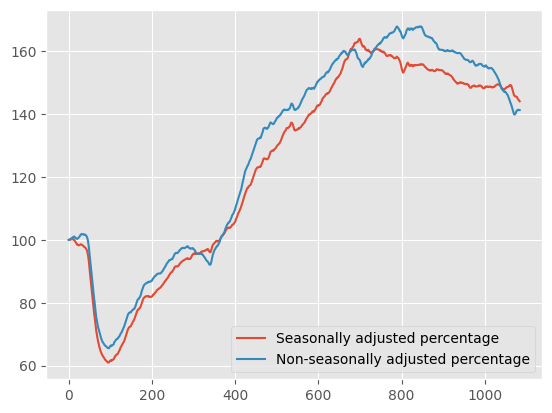

In [88]:
indeed_jobs[['Date', 'Seasonally adjusted percentage', 'Non-seasonally adjusted percentage']].plot()

In [89]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=indeed_jobs['Date'], y=indeed_jobs['Non-seasonally adjusted percentage'], 
               name="Indeed Job Postings", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Indeed vs Lightcast Job Postings, Relative to Jan 2020"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Indeed Job Postings", secondary_y=False)
fig.update_yaxes(title_text="Job Postings", secondary_y=True)

fig.show()

### Export Cleaned Data

In [90]:
total_layoffs_by_month.to_csv('data/monthly_layoffs.csv')
total_layoffs_by_month_us.to_csv('data/monthly_layoffs_us.csv')
total_layoffs_by_date.to_csv('data/daily_layoffs.csv')
total_layoffs_by_date_us.to_csv('data/daily_layoffs_us.csv')

In [91]:
job_postings_national.to_csv('data/job_postings.csv')

In [92]:
census_data_seas_total.to_csv('data/business_formations_seasonal.csv')
census_data_no_seas_total.to_csv('data/business_formations_nonseasonal.csv')

In [93]:
sector.to_csv('data/sector.csv')

## Dashboard

The below code sets up a Flask app for the Tech Labor Market Dashboard.

In [94]:
#[{'label': str(v), 'value': v} for v in mytotaldates.values()]

In [106]:
########## SETTING UP THE APPS ##########

flask_app = Flask(__name__)
external_stylesheets = [dbc.themes.BOOTSTRAP]
dash_app = Dash(__name__, external_stylesheets=external_stylesheets, server=flask_app) 
#,requests_pathname_prefix='/dash/') ####

########## HELPER FUNCTIONS ##########

jobs_forecast = pd.read_csv('data/jobs_forecast.csv')
dates = jobs_forecast.date
mytotaldates = {i:datetime.datetime.strptime(x, "%Y-%m-%d").date() for i,x in enumerate(dates)}
a = (list(mytotaldates.keys()))

def create_sliders(X):
    """
    creates sliders for use in user input (continous data) 
    for generating a prediction w/ layoff classification model
    """
    
    slider_items = []
    for column in X:
        label = html.H5(column)
        
        lower_bound = X[column].min()
        upper_bound = X[column].max()
        value = X[column].median()

        slider = dcc.Slider(
            min=lower_bound,
            max=upper_bound,
            value=value, # set median as default
            marks=None,
            tooltip={"always_visible": True},
            id=column # set id based on column name
        )

        item = dbc.ListGroupItem(children=[
            label,
            slider
        ])
        slider_items.append(item)
    return dbc.ListGroup(slider_items)

def layoff_prediction(industry, stage, country, funds_raised): # any other features
    """
    Given the above features, predict whether the company will have
    multiple rounds of layoffs
    """
    with open("final_classification_model.pkl", "rb") as f:
        model = joblib.load(f)
        
    X = [[industry, stage, country, funds_raised]]
    predictions = model.predict(X)
    # model.predict takes a list of records and returns a list of predictions
    # but we are only making a single prediction
    prediction = int(predictions[0])
    return {"predicted_class": prediction}

def check_prediction(selected_row_data):
    """
    Return an Alert component with information about the model's prediction
    vs. the true class value
    """
    data_copy = selected_row_data.copy()
    actual_class = data_copy.pop("class")
    # remove " (cm)" from labels
    data_cleaned = {k.split(" (cm)")[0].replace(" ", "_"):v for k, v in data_copy.items()} # DONT NEED THIS
    result = layoff_prediction(**data_cleaned)
    predicted_class = result["predicted_class"]
    correct_prediction = predicted_class == actual_class
    if correct_prediction:
        color = "success"
    else:
        color = "danger"
    return dbc.Alert(f"Predicted class: {predicted_class}", color=color)

######### LAYOUT / COMPONENTS #########

jobs_forecast = pd.read_csv('data/jobs_forecast.csv')
jobs_forecast.date = pd.to_datetime(jobs_forecast.date)

#graphs
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=sector['Date'], y=sector['Market Cap'], name="Market Cap", mode='lines'),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=sector['Date'], y=sector['Earnings'], name="Earnings", mode='lines'),
    secondary_y=True,
)
fig.update_layout(
    title_text="Tech Sector Market Cap & Earnings <br><sup>Source: Simple Wall Street</sup>"
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Market Cap</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Earnings</b>", secondary_y=True)

fig2 = px.bar(total_layoffs_by_month, x="month", y="total_laid_off", 
              title='Total Layoffs, Globally <br><sup>Source: layoffs.fyi</sup>', 
              color_discrete_sequence=["red"])

fig3 = px.line(census_data_seas_sectors[(census_data_seas_sectors['time']>='2020') & 
                                       (census_data_seas_sectors['sector']=='Information')], 
               x="time", y="cell_value",
               title='Business Formations, Information Sector, 2020 and later \
                       <br><sup>Source: U.S. Census Bureau</sup>', 
               color='sector', 
               color_discrete_sequence=['magenta'])

tech_stocks = pd.read_csv('data/IXN_ETF.csv')
fig4 = px.line(tech_stocks, x='date', y='close_px', 
               title='Global Tech iShares ETF (IXN), Closing Price \
                       <br><sup>Source: Yahoo Finance</sup>')

# prediction_layout = html.Div(children=[
#     create_sliders(X),
#     dbc.Alert("Prediction will go here", color="info", id="prediction-output")
# ]) 

markdown = dcc.Markdown("""
## 

Given the massive recent layoffs in the tech sector, I thought it would
be helpful to take a deeper look at the state of the tech market to get a 
sense of what is really going on behind the scenes -- and to see
whether there is hope for any of us out there who are looking for a job.

This dashboard is split into three sections - the first will give a general 
sense of economic conditions in the sector and more generally, the second
will take a closer look at recent layoffs and predict whether companies
will experience multiple rounds or just a one off, and the third will 
focus on job postings.

""")

past_data_layout = html.Div(children=[
    html.Div(markdown),
    html.Div(
        [dcc.Graph(figure=fig, style={"height":"520px"}), 
         dcc.Graph(figure=fig4, style={"height":"520px"}),
         dcc.Graph(figure=fig2, style={"height":"520px"}), 
         dcc.Graph(figure=fig3, style={"height":"520px"})
        ])
])

layoffs_layout = html.Div(children=[
    
    html.Div(
        [dcc.Graph(figure=fig5, style={"height":"520px"}),
         dcc.Graph(figure=fig6, style={"height":"520px"}),
         dcc.Graph(figure=fig7, style={"height":"520px"}),
         dcc.Graph(figure=fig8, style={"height":"520px"}),
         dcc.Graph(figure=fig9, style={"height":"520px"}),
        ])
])



## DROPDOWN ##
job_forecast_layout = html.Div(children=[
    html.Img(src='assets/job_forecast.png'),
    html.P("Select a date: "),
    html.Div([dcc.Dropdown(className = 'date_input', id='Datedropdown', 
                 options=[{'label': str(v), 'value': v} for v in mytotaldates.values()],
                 value=a[-1]
            ),
        html.Div(id='OutputContainer'), 
        
        #Calculate and Reset Buttons
        html.Div(
            [
                html.Button('Reset', id='btn_reset', n_clicks=0, 
                className= "btn_reset"),
                html.Button('Calculate', id='btn_calculate', n_clicks=0, 
                            className = "btn_calculate"),
            ],
         className="date_input", id="job-buttons"                         
         ),
            html.Div(id='OutputContainer2')

    ]) 
])


tabs = dbc.Tabs(children=[
        #tab1,
        dbc.Tab(past_data_layout, label="Economic Conditions"),
        dbc.Tab(layoffs_layout, label="Layoffs Dashboard"),
        dbc.Tab(job_forecast_layout, label="Job Postings")
    ])

####

dash_app.layout = dbc.Container(children=[
    html.H1("State of the Tech Labor Market"),
    tabs
])

########## CALLBACKS ##########

@dash_app.callback(Output('OutputContainer', 'children'), 
                   [Input('Datedropdown', 'value')]) # or Dateslider
def rangerselection(val):
    val = jobs_forecast.date[val]
    #return f'Selected Date: {str(value)}'
    return f"Predicted job postings, relative to Jan 2020: \
            {float(jobs_forecast.prediction[jobs_forecast.date==val])}"

@dash_app.callback(
    Output('OutputContainer', 'children'),
    [Input('btn_calculate', 'n_clicks')],
    [State('OutputContainer', 'value')],
)

def job_pred(n_clicks, value):
    if(n_clicks):
        return print(str(value)) #float(jobs_forecast.prediction[jobs_forecast.date==val])
    else:
        return('Error')

def render_information(rows, selected_rows):
    if selected_rows:
        # selection is set to "single" so there will be exactly 1 selected row
        selected_row_data = rows[selected_rows[0]]      
        return html.Div(dbc.Row(children=[
            dbc.Col(create_image_card(selected_row_data)),
            dbc.Col(children=[
                create_list_group(selected_row_data),
                html.Hr(),
                check_prediction(selected_row_data)
            ])
        ]))

########## ROUTES ##########

@flask_app.route('/predict', methods=['POST'])
def predict():
    request_json = request.get_json()
    result = iris_prediction(**request_json) ## need to fix
    return json.dumps(result)

## NEED TO ADD RESET

In [96]:
dash_app.run_server(mode="inline", height=150, host="localhost", port=5002, 
                    use_reloader=False)

## Appendix

In [97]:
# job_postings_layout = html.Div(children=[
    
#     html.Div([html.Img(src='assets/job_forecast.png')
#     html.Div([html.Div([
#                         html.H6("Job Postings Prediction", 
#                                 className = "job_pred_header_text"),
#                         html.H4("Job Postings, Relative to Jan 2020: ", 
#                                 id = "job_value", 
#                                 className = "job_pred_value_text")
#                     ], className = "job_card_header"),        
             
#               html.P("Select a date", className="date_input"), 
#               html.Div([dcc.Dropdown(className = 'date_input', id='date', 
#                                      options=[jobs_forecast.date], 
#                                      value='2023-02-03'),
#              ])


# ]) 

# dash_app.layout = html.Div(children=[   
#     dcc.Slider(
#         id='Dateslider',
#         min=a[0],
#         max=a[-1],
#         marks=mytotaldates,
#         value=a[-1],
#     ),
#     html.Div(id='OutputContainer')
# ])
   
## SLIDER ##    
# job_forecast_layout = html.Div(children=[
#     html.Img(src='assets/job_forecast.png'),
#     html.P("Select a date"),
#     dcc.Slider(
#         id='Dateslider',
#         min=a[0],
#         max=a[-1],
#         marks=mytotaldates,
#         value=a[-1],
#     ),
#     html.Div(id='OutputContainer')
#     #create_sliders(jobs_forecast.date),
#     #dbc.Alert("Prediction will go here", color="info", id="prediction-output")
# ]) 

# @dash_app.callback(
#     Output("prediction-output", "children"),
#     [
#         # list comprehension to specify all of the input columns
#         Input(jobs_forecast.date, "value")
#         #Input(column, "value") for column in X.columns
#     ]
# )
              
# def generate_jobs_forecast(date):
#     return f"Predicted class: {str(jobs_forecast['prediction'][jobs_forecast['date']==date])}"
    
# def generate_user_input_prediction(*args):
#     return f"Predicted class: {layoffs_prediction(*args)['predicted_class']}"
    
    
# @dash_app.callback(
#     Output('Datedropdown', 'value'),
    
#     [Input('btn_reset', 'n_clicks')]
# )

# def reset_button(n_clicks):
#     if n_clicks:
#         return value
#     else:
#         return print('Error')

#@dash_app.callback(Output("modal", "is_open"), Input("tbl", "selected_rows"))
#def toggle_modal(selected_rows):
#    if selected_rows:
#        return True
#    else:
#        return False
    
# @dash_app.callback(
# Output('dd-output-container', 'children'), ###
# [Input('date', 'value')])

# def update_output(value):
#     return jobs_forecast['prediction'][jobs_forecast['date']==value]

# @dash_app.callback(
#    Output("modal-body", "children"),
#    [Input("tbl", "derived_virtual_data"), Input("tbl", "selected_rows")])

In [98]:
## SIZE OF TECH INDUSTRY GRAPH??
## TOP 5 TECH COMPANIES SIZE OF WORKFORCE
## BARCHART WITH COLORS FOR LAST 3 YEARS

In [99]:
# fig = px.line(womp_national, x="date", y="merchants_all", 
#               title='Percent change in number of small businesses open, relative to Jan 2020')
# fig.show()

In [100]:
# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=womp_national['date'], y=womp_national['merchants_all'], name="Business Openings", mode='lines'),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=womp_national['date'], y=womp_national['revenue_all'], name="Revenue", mode='lines'),
#     secondary_y=True,
# )

# # Add figure title
# fig.update_layout(
#     title_text="Small Business Openings and Revenues, Relative to Jan 2020"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Date")

# # Set y-axes titles
# fig.update_yaxes(title_text="Small Business <b>Openings</b>", secondary_y=False)
# fig.update_yaxes(title_text="Small Business <b>Revenues</b>", secondary_y=True)

# fig.show()

In [101]:
# fig = px.line(womp_national, x="date", y="revenue_all", 
#               title='Percent change in net revenue for small businesses, relative to Jan 2020')
# fig.show()

In [102]:
# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=womp_national['date'], y=womp_national['merchants_all'], 
#                name="Business Openings", mode='lines'),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
#                name="Job Postings", mode='lines'),
#     secondary_y=True,
# )

# # Add figure title
# fig.update_layout(
#     title_text="Small Business Openings and Job Postings, Relative to Jan 2020"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Date")

# # Set y-axes titles
# fig.update_yaxes(title_text="Small Business Openings", secondary_y=False)
# fig.update_yaxes(title_text="Job Postings", secondary_y=True)

# fig.show()